# Exploratory Data Analysis

Layout:

* Preview the Data

* Check missing values

* Impute data

* Clustering Samples

    * Using Continuous Variables

    * Using Categorical Variables

In [1]:
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

## Preview Data

We load all the data and convert all features to either categorical or float64 types in order to simplify the analysis

In [2]:
buffer = StringIO(
    ",".join([
        "symboling",
        "normalized-losses",
        "make",
        "fuel-type",
        "aspiration",
        "num-of-doors",
        "body-style",
        "drive-wheels",
        "engine-location",
        "wheel-base",
        "length",
        "width",
        "height",
        "curb-weight",
        "engine-type",
        "num-of-cylinders",
        "engine-size",
        "fuel-system",
        "bore",
        "stroke",
        "compression-ratio",
        "horsepower",
        "peak-rpm",
        "city-mpg",
        "highway-mpg",
        "price"])
    + "\n"
    + open(Path("automobile") / "imports-85.data", "r").read()
)

data = pd.read_csv(buffer)

In [3]:
data = (
    data
    .replace("?", float("nan"))
)

In [4]:
data = (
    data
    .astype({
        "symboling": "float64",
        "normalized-losses": "float64",
        "make": "category",
        "fuel-type": "category",
        "aspiration": "category",
        "num-of-doors": "category",
        "body-style": "category",
        "drive-wheels": "category",
        "engine-location": "category",
        "wheel-base": "float64",
        "length": "float64",
        "width": "float64",
        "height": "float64",
        "curb-weight": "float64",
        "engine-type": "category",
        "num-of-cylinders": "category",
        "engine-size": "float64",
        "fuel-system": "category",
        "bore": "float64",
        "stroke": "float64",
        "compression-ratio": "float64",
        "horsepower": "float64",
        "peak-rpm": "float64",
        "city-mpg": "float64",
        "highway-mpg": "float64",
        "price": "float64"})
)

display(data.head())

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3.0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152.0,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109.0,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136.0,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


## Missing Values

We now determine the number of missing values in the features.

As shown below, the `normalized-losses` has many missing values, so we decide to drop the feature. Additionally, we decide to drop any rows without `price` or `num-of-doors`.

The missing values for the `bore`, `stroke`, `horsepower` and `peak-rpm` are imputed using a k-nearest neighbors algorithm.

In [5]:
(
    data
    .isna()
    .sum()
)

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

### Impute Values

In [6]:
data, target = (
    data
    .loc[lambda x: ~x[["price", "num-of-doors"]].isna().any(axis=1)]
    .drop("normalized-losses", axis=1)
    .pipe(
        lambda x:
        x.assign(**dict(
            KNNImputer()
            .set_output(transform="pandas")
            .fit_transform(x.select_dtypes(include="float64").drop("price", axis=1))
            .items())))
    .reset_index(drop=True)
    .pipe(
        lambda x:
        (x.drop("price", axis=1), x["price"]))
)

display(
    data
    .style
    .set_table_styles([{
        'selector': '',
        'props': 'width: 1000px; overflow-x: scroll; height: 250px; overflow-y: scroll; display: inline-block;'}])
    .set_sticky(axis=1)
)

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,3.000000,alfa-romero,gas,std,two,convertible,rwd,front,88.600000,168.800000,64.100000,48.800000,2548.000000,dohc,four,130.000000,mpfi,3.470000,2.680000,9.000000,111.000000,5000.000000,21.000000,27.000000
1,3.000000,alfa-romero,gas,std,two,convertible,rwd,front,88.600000,168.800000,64.100000,48.800000,2548.000000,dohc,four,130.000000,mpfi,3.470000,2.680000,9.000000,111.000000,5000.000000,21.000000,27.000000
2,1.000000,alfa-romero,gas,std,two,hatchback,rwd,front,94.500000,171.200000,65.500000,52.400000,2823.000000,ohcv,six,152.000000,mpfi,2.680000,3.470000,9.000000,154.000000,5000.000000,19.000000,26.000000
3,2.000000,audi,gas,std,four,sedan,fwd,front,99.800000,176.600000,66.200000,54.300000,2337.000000,ohc,four,109.000000,mpfi,3.190000,3.400000,10.000000,102.000000,5500.000000,24.000000,30.000000
4,2.000000,audi,gas,std,four,sedan,4wd,front,99.400000,176.600000,66.400000,54.300000,2824.000000,ohc,five,136.000000,mpfi,3.190000,3.400000,8.000000,115.000000,5500.000000,18.000000,22.000000
5,2.000000,audi,gas,std,two,sedan,fwd,front,99.800000,177.300000,66.300000,53.100000,2507.000000,ohc,five,136.000000,mpfi,3.190000,3.400000,8.500000,110.000000,5500.000000,19.000000,25.000000
6,1.000000,audi,gas,std,four,sedan,fwd,front,105.800000,192.700000,71.400000,55.700000,2844.000000,ohc,five,136.000000,mpfi,3.190000,3.400000,8.500000,110.000000,5500.000000,19.000000,25.000000
7,1.000000,audi,gas,std,four,wagon,fwd,front,105.800000,192.700000,71.400000,55.700000,2954.000000,ohc,five,136.000000,mpfi,3.190000,3.400000,8.500000,110.000000,5500.000000,19.000000,25.000000
8,1.000000,audi,gas,turbo,four,sedan,fwd,front,105.800000,192.700000,71.400000,55.900000,3086.000000,ohc,five,131.000000,mpfi,3.130000,3.400000,8.300000,140.000000,5500.000000,17.000000,20.000000
9,2.000000,bmw,gas,std,two,sedan,rwd,front,101.200000,176.800000,64.800000,54.300000,2395.000000,ohc,four,108.000000,mpfi,3.500000,2.800000,8.800000,101.000000,5800.000000,23.000000,29.000000


## Variables Distribution

We observe the distribution of the values in each feature.

Afterwards, we evaluate the correlation between pairs of numerical features. While displaying the correlation matrix, we attempt group highly correlated features in blocks along the main diagonal in order to help identify relevant relations.

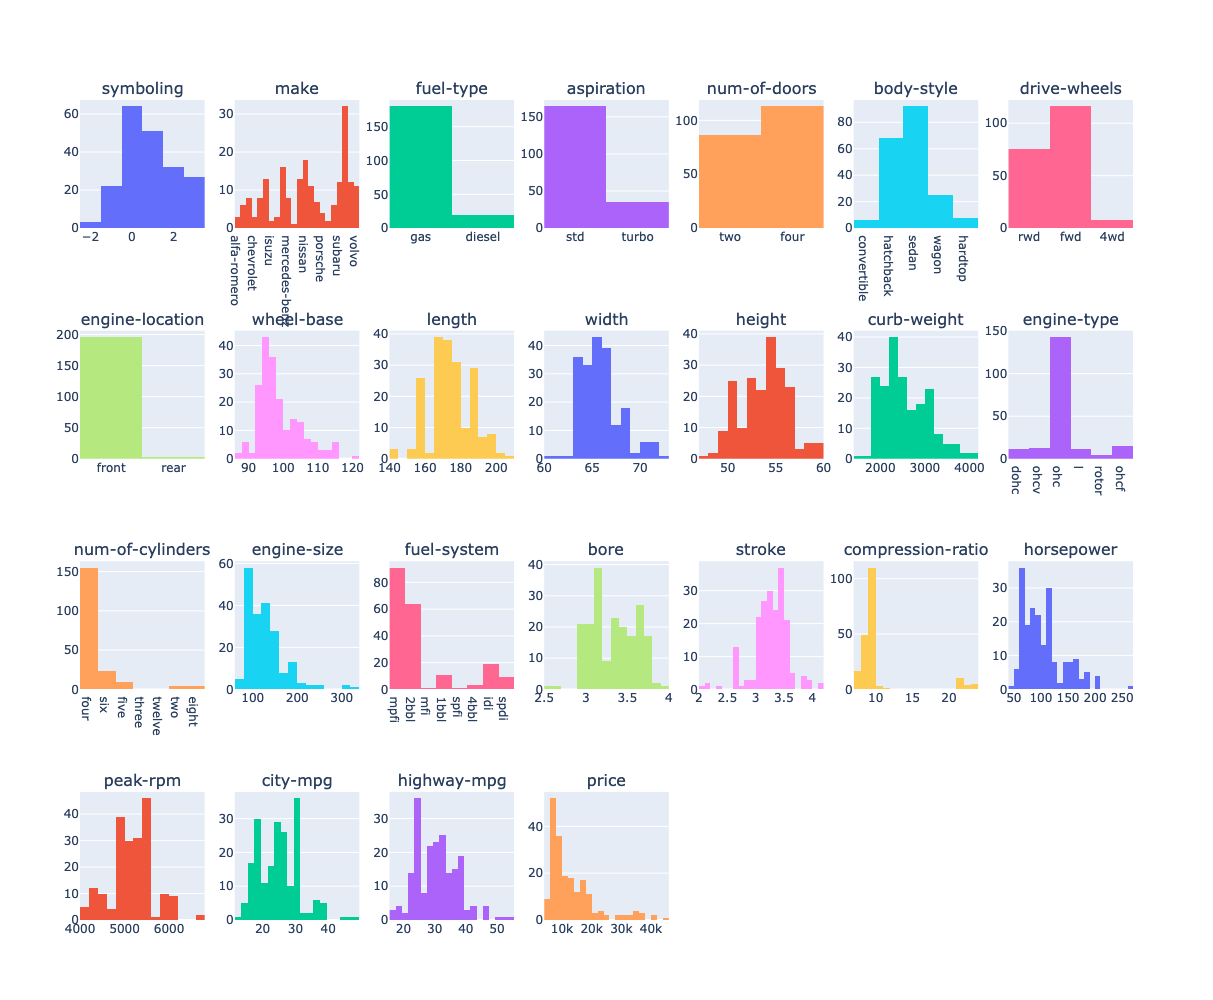

In [24]:

fig = make_subplots(rows=4, cols=7, subplot_titles=data.columns.tolist() + ["price"])

for i, col in enumerate(data.columns):
    fig.add_trace(
        go.Histogram(x=data[col]),
        row=i // 7 + 1,
        col=i % 7 + 1,
    )

i += 1
fig.add_trace(
    go.Histogram(x=target),
    row=i // 7 + 1,
    col=i % 7 + 1,
)

fig.update_layout(showlegend=False, height=1000, width=1200).show()

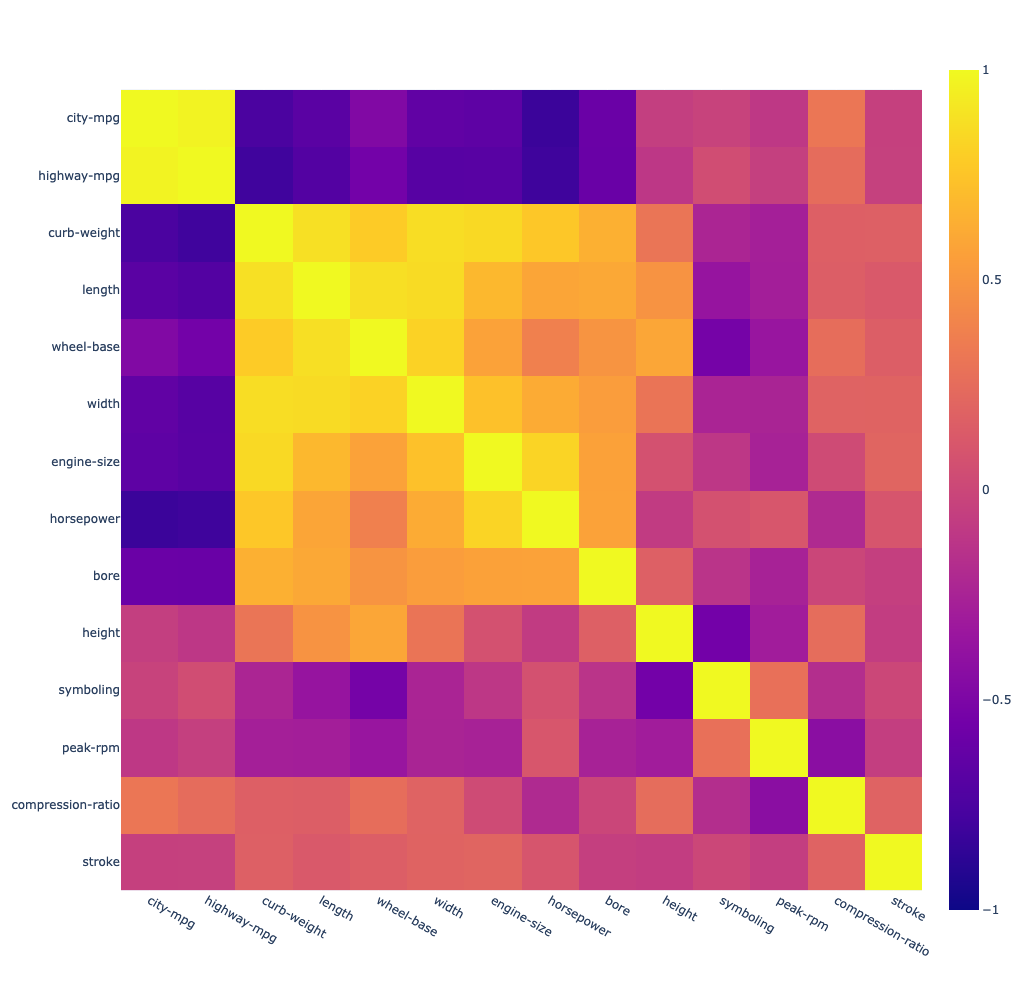

In [8]:
px.imshow(
    data
    [[
        "city-mpg",
        "highway-mpg",
        "curb-weight",
        "length",
        "wheel-base",
        "width",
        "engine-size",
        "horsepower",
        "bore",
        "height",
        "symboling",
        "peak-rpm",
        "compression-ratio",
        "stroke"]]
    .select_dtypes(include="float64").corr(),
    zmin=-1,
    zmax=1,
).update_layout(height=1000).show()


## Clustering

We determine groups for the car samples based on the k-means algorithms.

The number of clusters is determined comparing different option for that hyperparameter and using an elbow rule.

### Continuous Variables

In [9]:
m1 = (
    Pipeline(steps=[
        (
            "zero", 
            ColumnTransformer([
                ("zero", "passthrough", lambda x: x.select_dtypes(include="float64").columns.tolist())])
            .set_output(transform="pandas")),
        ("first", MinMaxScaler().set_output(transform="pandas")),
        ("second", KMeans())])
    .fit(data)
)

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-pac

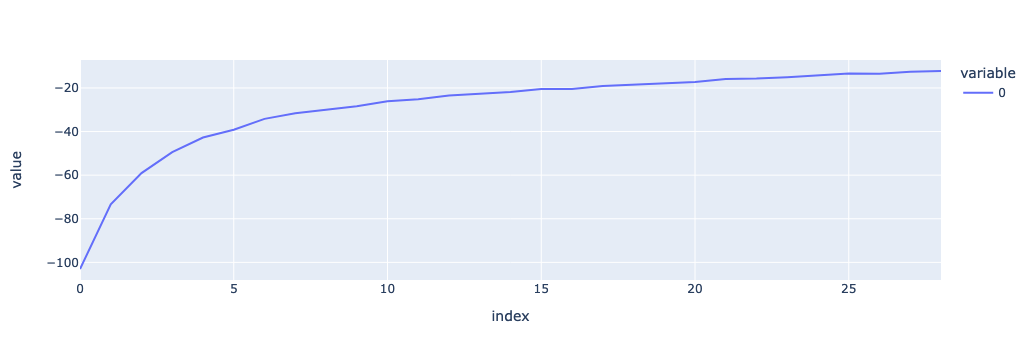

In [10]:

inertia = []
for i in range(1, 30):
    m1 = clone(m1)
    m1.set_params(**{"second__n_clusters": i})
    m1.fit(data.select_dtypes(include="float64"))
    inertia.append(m1.score(data.select_dtypes(include="float64")))

px.line(inertia).show()

In [11]:
m1 = clone(m1)
m1.set_params(**{"second__n_clusters": 5})
m1.fit(data.select_dtypes(include="float64"))


/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('zero',
                 ColumnTransformer(transformers=[('zero', 'passthrough',
                                                  <function <lambda> at 0x2873a7240>)])),
                ('first', MinMaxScaler()), ('second', KMeans(n_clusters=5))])

/var/folders/ms/k8qk87f53t34nmls62cfs0280000gp/T/ipykernel_23951/2679928723.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



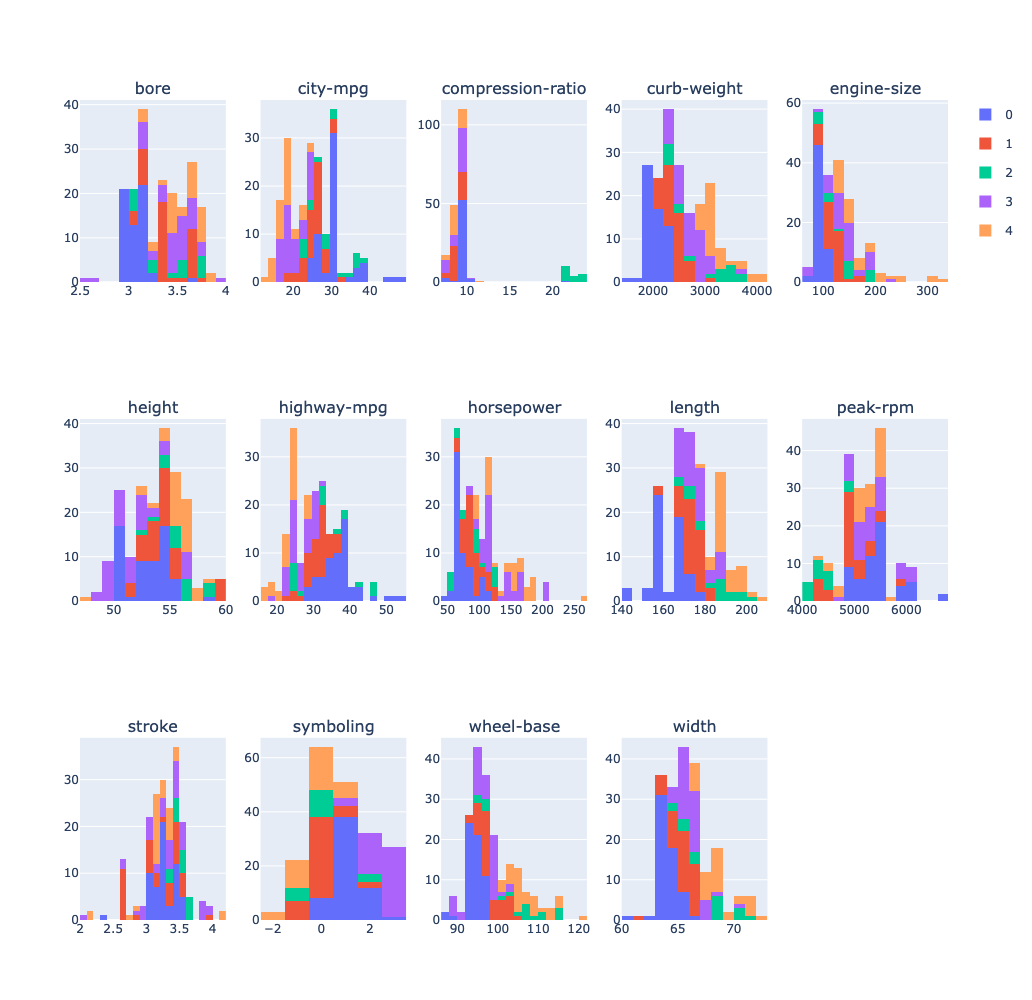

In [21]:
fig = make_subplots(rows=3, cols=5, subplot_titles=data.select_dtypes(include="float64").columns.sort_values())

for i, (col, df) in enumerate(iter(
    data
    .select_dtypes(include="float64")
    .assign(group=lambda x: m1.predict(x))
    .astype({"group": "category"})
    .melt(id_vars=["group"])
    .sort_values("variable")
    .groupby("variable", as_index=False)
)):
    for j, df1 in iter(df.groupby("group", as_index=False)):
        fig.add_trace(
            go.Histogram(
                x=df1["value"], 
                name=j, 
                legendgroup=str(j), showlegend=False,
                marker=dict(color=px.colors.qualitative.Plotly[int(j) % 10])),
            row=i // 5 + 1,
            col=i % 5 + 1,
        )

for j in df["group"].sort_values().unique():
    fig.add_trace(
        go.Histogram(
            x=[float("nan")], y=[float("nan")],
            name=j,
            legendgroup=str(j),
            showlegend=True,
            marker=dict(color=px.colors.qualitative.Plotly[int(j) % 10])),
        row=i // 5 + 1,
        col=i % 5 + 1,
    )

fig.update_layout(showlegend=True, height=1000, barmode="stack").show()

#### Examples

In [13]:
(
    data
    .assign(group=lambda x: m1.predict(x.select_dtypes(include="float64")))
    [["group", "make"]]
    .groupby("group")
    .apply(lambda x: x.head(2)["make"].tolist())
)

group
0        [chevrolet, chevrolet]
1                    [bmw, bmw]
2        [mazda, mercedes-benz]
3    [alfa-romero, alfa-romero]
4                  [audi, audi]
dtype: object

### Categorical Variables

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/joaomatias/miniconda3/lib/python3.11/site-pac

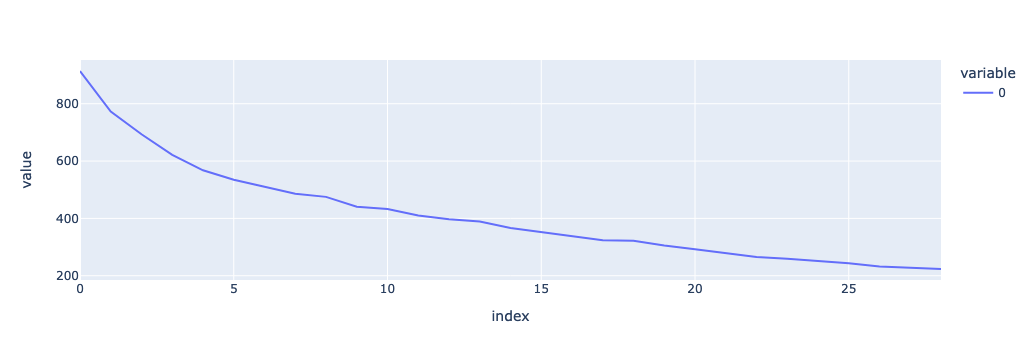

In [14]:

m2 = Pipeline(steps=[
    (
        "zero", 
        ColumnTransformer([
            ("zero", "passthrough", lambda x: x.select_dtypes(include="category").columns.tolist())])
        .set_output(transform="pandas")),
    ("first", OneHotEncoder(categories=[v.unique().tolist() for k, v in data.select_dtypes(include="category").items()])),
    ("second", KMeans()),
])

inertia = []
for i in range(1, 30):
    m2 = clone(m2)
    m2.set_params(**{"second__n_clusters": i})
    m2.fit(data.select_dtypes(include="category"))
    inertia.append(m2.named_steps.second.inertia_)

px.line(inertia).show()

In [15]:
m2 = clone(m2)
m2.set_params(**{"second__n_clusters": 5})
m2.fit(data.select_dtypes(include="category"))

/Users/joaomatias/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('zero',
                 ColumnTransformer(transformers=[('zero', 'passthrough',
                                                  <function <lambda> at 0x28d3f3380>)])),
                ('first',
                 OneHotEncoder(categories=[['alfa-romero', 'audi', 'bmw',
                                            'chevrolet', 'dodge', 'honda',
                                            'isuzu', 'jaguar', 'mazda',
                                            'mercedes-benz', 'mercury',
                                            'mitsubishi', 'nissan', 'peugot',
                                            'plymouth', 'porsche', 'renault',
                                            'saab', 'subaru', 'toyota',
                                            'volkswagen', 'volvo'],
                                           ['gas', 'diesel'], ['std', 'turbo'],
                                           ['two', 'four'],
                                           ['convertible', 'hatchback', 'sedan',
                                            'wagon', 'hardtop'],
                                           ['rwd', 'fwd', '4wd'],
                                           ['front', 'rear'],
                                           ['dohc', 'ohcv', 'ohc', 'l', 'rotor',
                                            'ohcf'],
                                           ['four', 'six', 'five', 'three',
                                            'twelve', 'two', 'eight'],
                                           ['mpfi', '2bbl', 'mfi', '1bbl',
                                            'spfi', '4bbl', 'idi', 'spdi']])),
                ('second', KMeans(n_clusters=5))])

/var/folders/ms/k8qk87f53t34nmls62cfs0280000gp/T/ipykernel_23951/3611817639.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



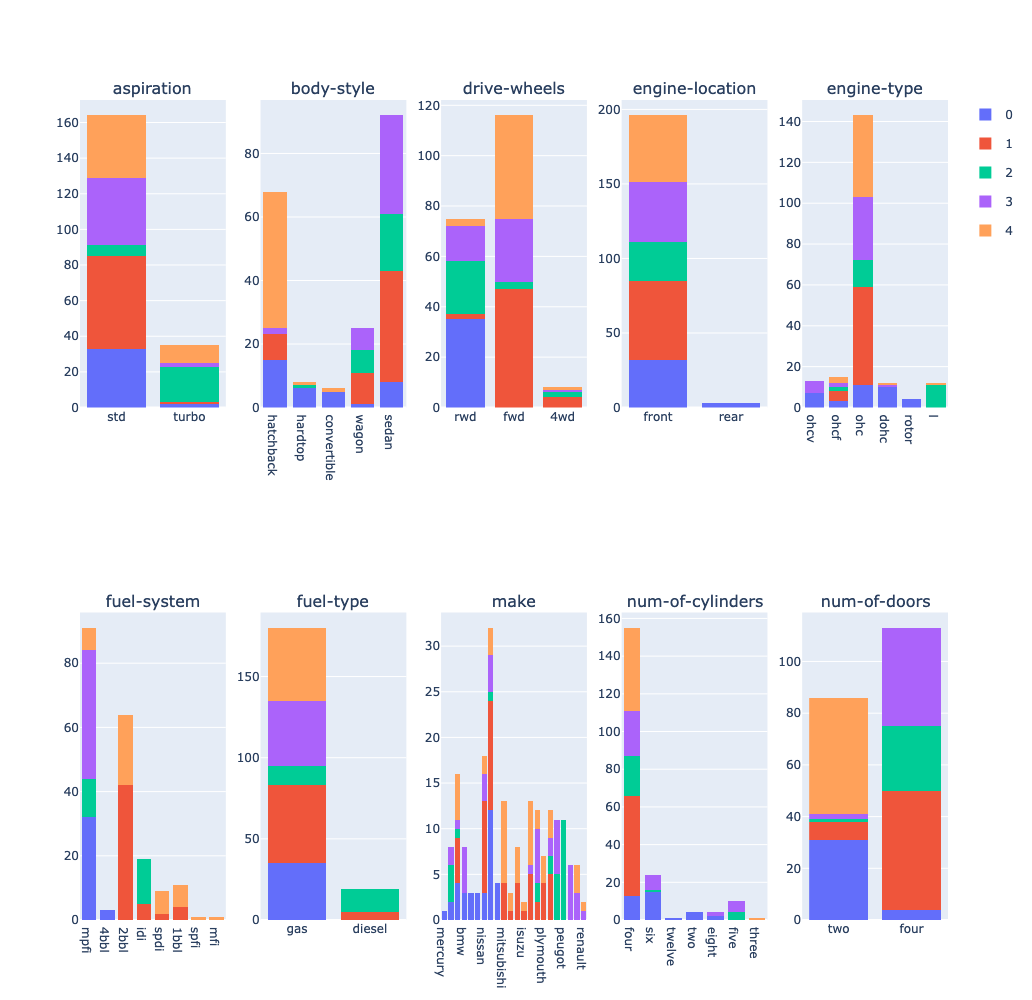

In [16]:
fig = make_subplots(rows=2, cols=5, subplot_titles=data.select_dtypes(include="category").columns.sort_values())

for i, (col, df) in enumerate(iter(
    data
    .select_dtypes(include="category")
    .assign(group=lambda x: m2.predict(x.select_dtypes("category")))
    .astype({"group": "category"})
    .melt(id_vars=["group"])
    .sort_values("variable")
    .groupby("variable", as_index=False)
)):
    for j, df1 in iter(df.groupby("group", as_index=False)):
        fig.add_trace(
            go.Histogram(
                x=df1["value"],
                name=j,
                legendgroup=str(j),
                showlegend=False,
                marker=dict(color=px.colors.qualitative.Plotly[int(j) % 10])),
            row=i // 5 + 1,
            col=i % 5 + 1,
        )

for j in df["group"].sort_values().unique():
    fig.add_trace(
        go.Histogram(
            x=[float("nan")], y=[float("nan")],
            name=j,
            legendgroup=str(j),
            showlegend=True,
            marker=dict(color=px.colors.qualitative.Plotly[int(j) % 10])),
        row=i // 5 + 1,
        col=i % 5 + 1,
    )

fig.update_layout(showlegend=True, height=1000, barmode="stack").show()

#### Examples

In [19]:
(
    data
    .assign(group=lambda x: m2.predict(x.select_dtypes(include="category")))
    [["group", "make"]]
    .groupby("group")
    .apply(lambda x: x.head(2)["make"].tolist())
)

group
0    [alfa-romero, alfa-romero]
1            [chevrolet, dodge]
2        [mazda, mercedes-benz]
3                  [audi, audi]
4        [chevrolet, chevrolet]
dtype: object

#### Estimate Categorical Feature Importance

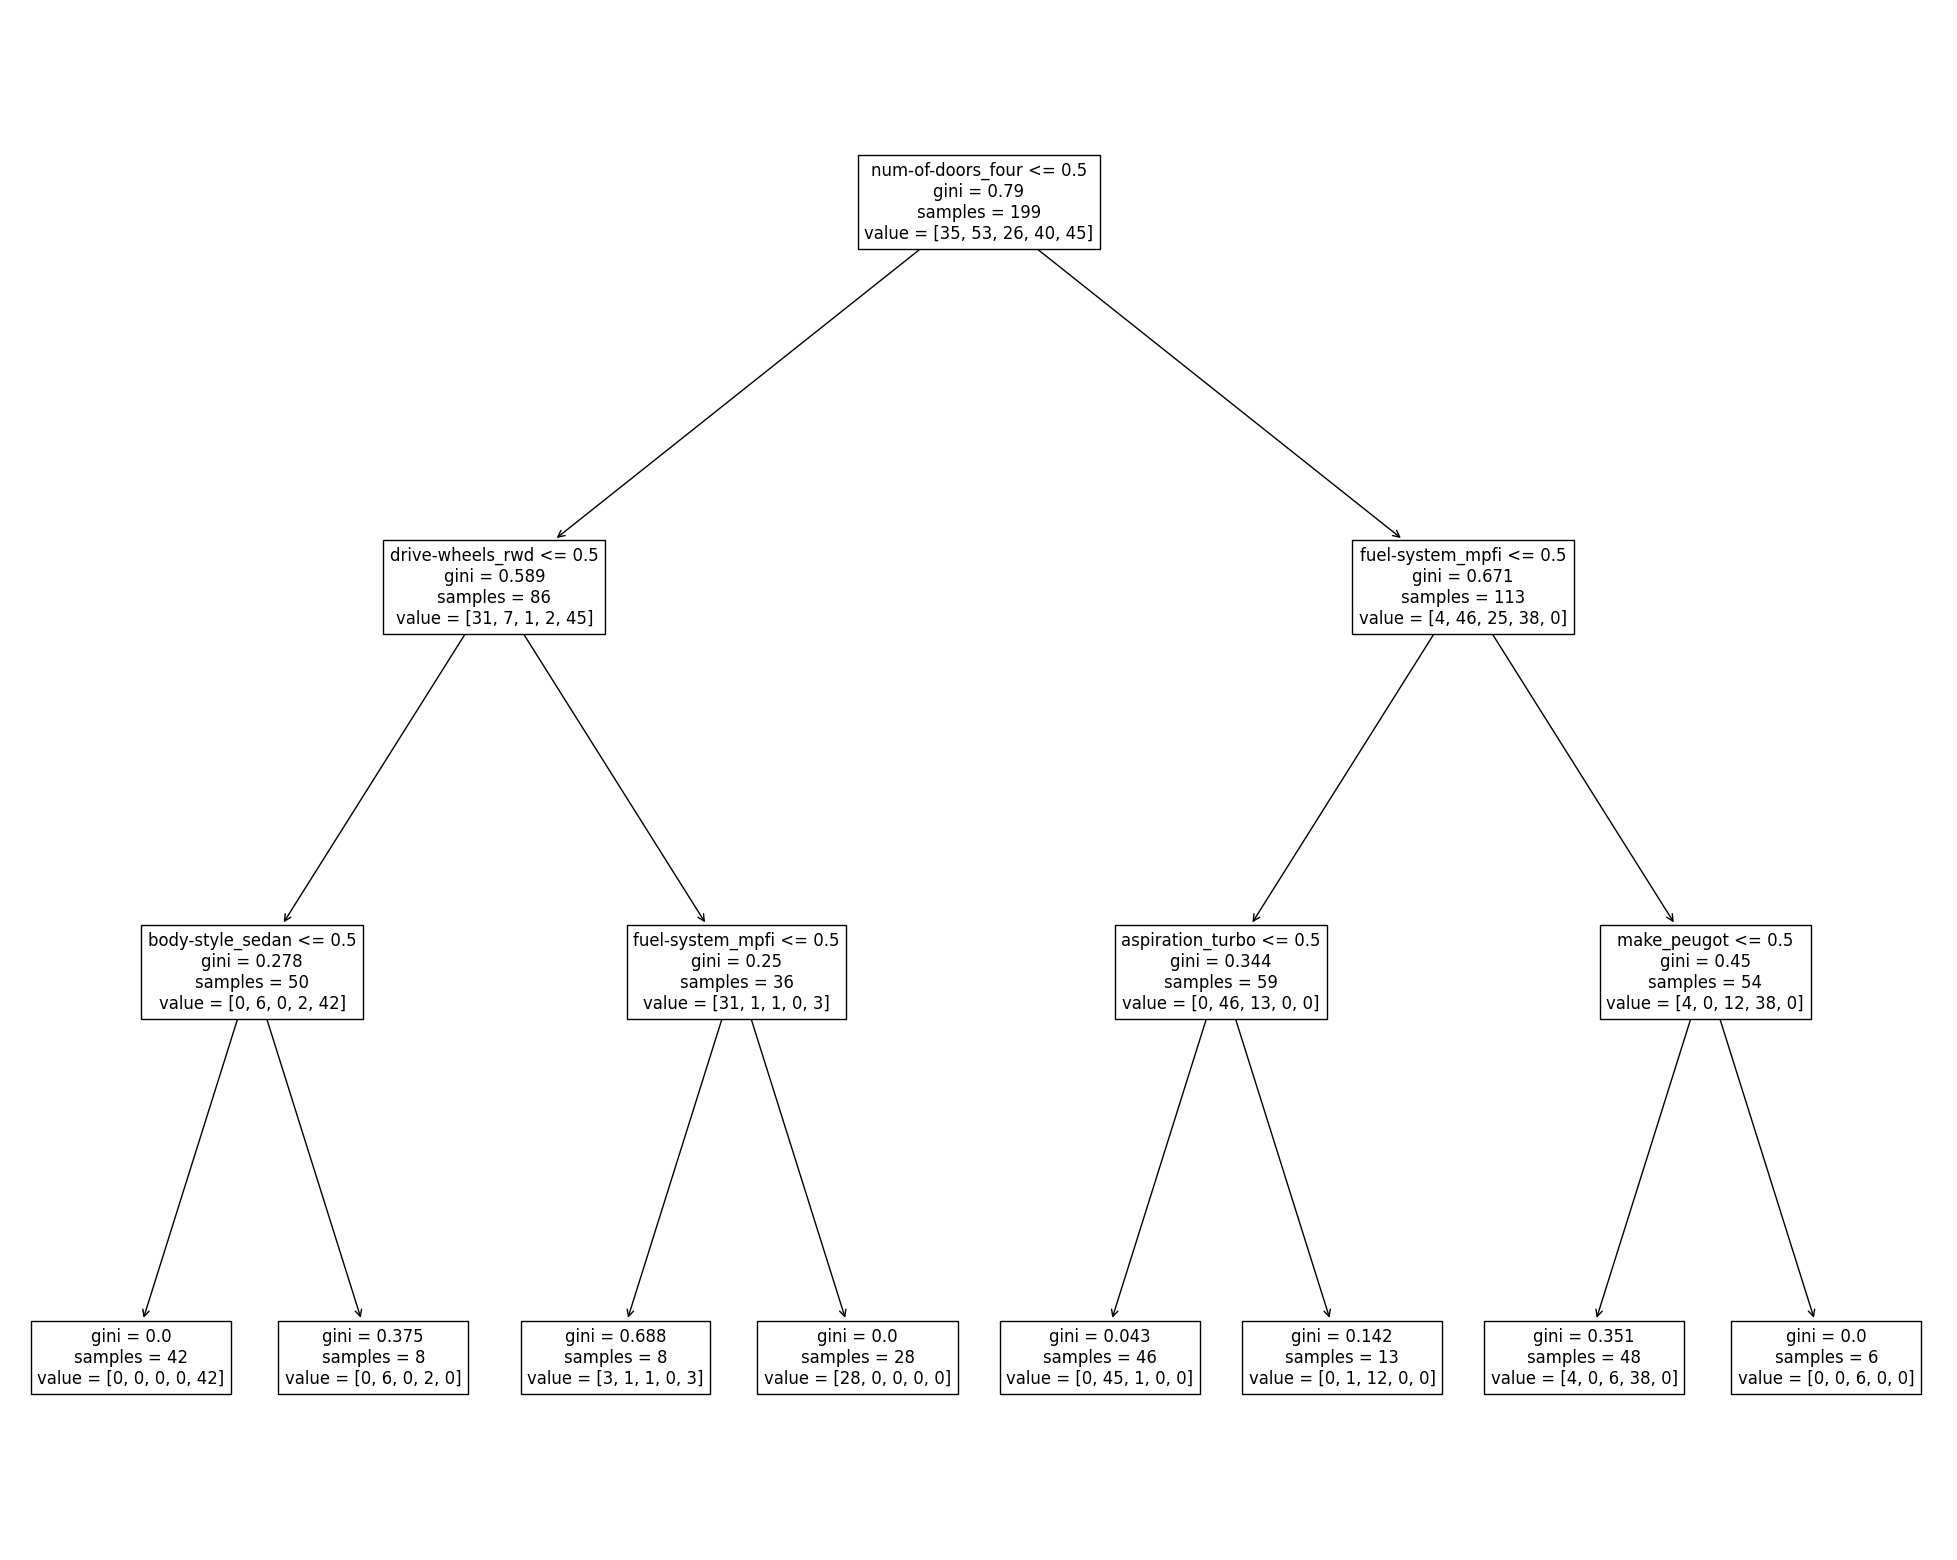

In [17]:
m3 = Pipeline(steps=[
    ("first", OneHotEncoder(categories=[v.unique().tolist() for k, v in data.select_dtypes(include="category").items()])),
    ("second", DecisionTreeClassifier(max_depth=3))
])

m3.fit(data.select_dtypes(include="category"), m2.predict(data.select_dtypes(include="category")))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(m3.named_steps.second, feature_names=m3.named_steps.first.get_feature_names_out())

In [18]:
pd.Series(
    m3.named_steps.second.feature_importances_,
    index=m3.named_steps.first.get_feature_names_out(),
).loc[lambda x: x > 0].sort_values(ascending=False)

fuel-system_mpfi     0.271571
num-of-doors_four    0.239424
drive-wheels_rwd     0.216684
aspiration_turbo     0.128681
body-style_sedan     0.085326
make_peugot          0.058314
dtype: float64